In [1]:
import pandas as pd
from PIL import Image
from IPython.display import clear_output 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch
from torchvision.utils import make_grid
from torchvision.io import read_image
from torchvision import models, transforms
import sys
import os
from PIL import Image
import torch
# import torch.functional as F
import numpy as np
clear_output()
import glob
from utils import *
from datetime import date

In [2]:
def get_feature_importance(data, ranknet, device='cpu', type='32x32'):
    model = ranknet.fextractor.to(device)
    x1 = model(data[0].unsqueeze(0).to(device)).unsqueeze(2)
    x2 = model(data[1].unsqueeze(0).to(device)).unsqueeze(2)
    sigm = torch.nn.Sigmoid()(torch.matmul(x1, torch.ones((x1.shape[0],1,32)).to(device)) - torch.matmul(x2, torch.ones((x2.shape[0],1,32)).to(device)))

    if(type == '10'):
        sigm = torch.nn.Sigmoid()(x1-x2)
        
    X_test = torch.flatten(sigm, 1)
    fa = FeatureAblation(ranknet.dense.cpu())
    fa_attr_test = fa.attribute(X_test.cpu(), target=1)
    fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
    fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)
    return fa_attr_test_norm_sum

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def find_heatmap(ranknet, imageA, imageB, fA, fB, feature_extractor='resnet50'):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    model_pretrained = ranknet.fextractor
    model = model_pretrained
    if(feature_extractor == 'resnet50'):
        target_layers = [model.layer4[-1]]
    elif(feature_extractor == 'vgg19'):
        target_layers = [model.features[-1]]
    elif(feature_extractor == 'vit16'):
        target_layers = [model.encoder.layers.encoder_layer_11.ln_1]
    else:
        assert False, 'No feature_extractor name found'

    # input_tensor = data_transforms['test'](Image.open("./datasets/longtitude/90007-L/90007-LU306-L.jpg")).unsqueeze(0) # Create an input tensor image for your model..
    input_tensorA = imageA.unsqueeze(0)
    input_tensorB = imageB.unsqueeze(0)
    
    # Note: input_tensor can be a batch tensor with several images!
    rgb_imgA = imgtensor2array(input_tensorA[0], mean=mean, std=std)
    rgb_imgB = imgtensor2array(input_tensorB[0], mean=mean, std=std)

    # Construct the CAM object once, and then re-use it on many images:
    if(feature_extractor == 'vit16'):
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True, reshape_transform=reshape_transform)
    else:
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    
    grayscale_camA = cam(input_tensor=input_tensorA, targets=[ClassifierOutputTarget(fA)])
    grayscale_camB = cam(input_tensor=input_tensorB, targets=[ClassifierOutputTarget(fB)])
    
    return rgb_imgA, rgb_imgB, grayscale_camA, grayscale_camB 

def calculate_iou(pred_mask, gt_mask, true_pos_only):
    """
    Calculate IoU score between two segmentation masks.

    Args:
        pred_mask (np.array): binary segmentation mask
        gt_mask (np.array): binary segmentation mask
    Returns:
        iou_score (np.float64)
    """
    intersection = np.logical_and(pred_mask, gt_mask)
    union = np.logical_or(pred_mask, gt_mask)

    if true_pos_only:
        if np.sum(pred_mask) == 0 or np.sum(gt_mask) == 0:
            iou_score = np.nan
        else:
            iou_score = np.sum(intersection) / (np.sum(union))
    else:
        if np.sum(union) == 0:
            iou_score = np.nan
        else:
            iou_score = np.sum(intersection) / (np.sum(union))

    return iou_score

In [3]:
mean = [0.6821, 0.4575, 0.2626]
std = [0.1324, 0.1306, 0.1022]#[0.5904, 0.5008, 0.3771]#[0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}
test_glaucoma = pd.read_csv('/mnt/c/Users/PCM/Dropbox/Test_glaucoma.csv').dropna().reset_index()
test_glaucoma

,index,imagea,imageb,timeindicator,xpertlabel
0,0,90007-SI488-L.jpg,90007-LU306-L.jpg,0,0.0
1,1,91504-XY393-L.jpg,91504-CT673-L.jpg,1,1.0
2,2,91555-PL866-L.jpg,91555-DD423-L.jpg,0,1.0
3,6,90283-MN048-L.jpg,90283-IJ241-L.jpg,0,1.0
4,7,90326-DM545-L.jpg,90326-PD566-L.jpg,1,1.0


## GradCAM Auto Run Siamese 10

In [46]:
# Load model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fextractor = 'vgg19'

path = f"/mnt/c/Users/PCM/Dropbox/pretrained/mdindex/siamese10/{fextractor}/siaseme10_modemdindex-longtitude_fextravgg19_lr0.0005_mo0.9_e16_14102023_l10000_cotrainTrue.pt"
fcnet = nn.Sequential(torch.nn.Linear(25088, 256),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(256, 64),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(64, 10))
ranknet = RankNet_wresnet2(feature_extractor = fextractor, fcnet=fcnet)
ranknet.load_state_dict(torch.load(path, map_location=torch.device('cpu')), strict=False)
ranknet.eval()
ranknet.to(device)

RankNet_wresnet2(
  (fextractor): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True

In [47]:
IoUs = []

for idx in [0,1,2,3,4]:
    maskA = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glaucoma10-annot-ben/' + test_glaucoma.imagea[idx]))[1] < 0
    maskB = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glaucoma10-annot-ben/' + test_glaucoma.imageb[idx]))[1] < 0
    
    imageA = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glauLarge/' + test_glaucoma.imagea[idx].replace('-S.jpg', '-L.jpg')))
    imageB = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glauLarge/' + test_glaucoma.imageb[idx].replace('-S.jpg', '-L.jpg')))
    
    fa_attr_test_norm_sum = get_feature_importance([imageA, imageB], ranknet, device, type='10')
    importants_idx = np.flip(np.argsort((fa_attr_test_norm_sum)))
    topk = 3
    
    avg_camA = []
    avg_camB = []
    for j in range(topk):
        # j = 0
        # print(f'feature A index {np.mod(importants_idx[j],32)} and feature B index {int(importants_idx[j]/32)}')
        fA = importants_idx[j] if(fextractor=='resnet50') else 0
        fB = importants_idx[j] if(fextractor=='resnet50') else 0
        rgb_imgA, rgb_imgB, grayscale_camA, grayscale_camB = find_heatmap(ranknet, imageA, imageB, fA, fB, feature_extractor=fextractor)
        avg_camA.append(grayscale_camA)
        avg_camB.append(grayscale_camB)
    threA = np.mean(np.sum(avg_camA, 0)[0]) + np.std(np.sum(avg_camA, 0)[0])
    threB = np.mean(np.sum(avg_camB, 0)[0]) + np.std(np.sum(avg_camB, 0)[0])    
    iouA = calculate_iou(maskA.numpy(), np.sum(avg_camA, 0)[0] > threA, False)
    iouB = calculate_iou(maskB.numpy(), np.sum(avg_camB, 0)[0] > threB, False)
    print('iouA', iouA, 'iouB', iouB)
    IoUs.append(iouA)
    IoUs.append(iouB)

iouA 0.0 iouB 0.01680327868852459
iouA 0.0 iouB 0.013937719738824711
iouA 0.0 iouB 0.0
iouA 0.027466937945066123 iouB 0.008942390369733448
iouA 0.0 iouB 0.0


In [44]:
np.mean(IoUs)

0.006715032674214888

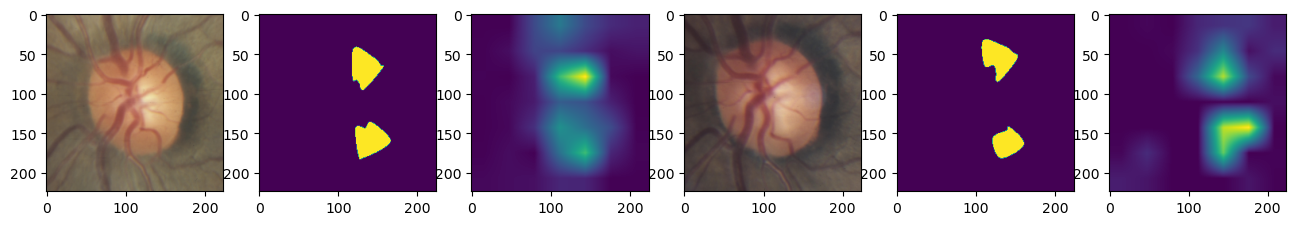

In [29]:
fig, axes = plt.subplots(1, 6, figsize=(16, 4))
ax = axes.ravel()
ax[0].imshow(imgtensor2array(imageA, mean=mean, std=std))
ax[1].imshow(maskA)
ax[2].imshow(np.sum(avg_camA, 0)[0])
ax[3].imshow(imgtensor2array(imageB, mean=mean, std=std))
ax[4].imshow(maskB)
ax[5].imshow(np.sum(avg_camB, 0)[0])

In [42]:
importants_idx

array([9, 1, 6, 0, 4, 7, 3, 5, 8, 2])

<BarContainer object of 10 artists>

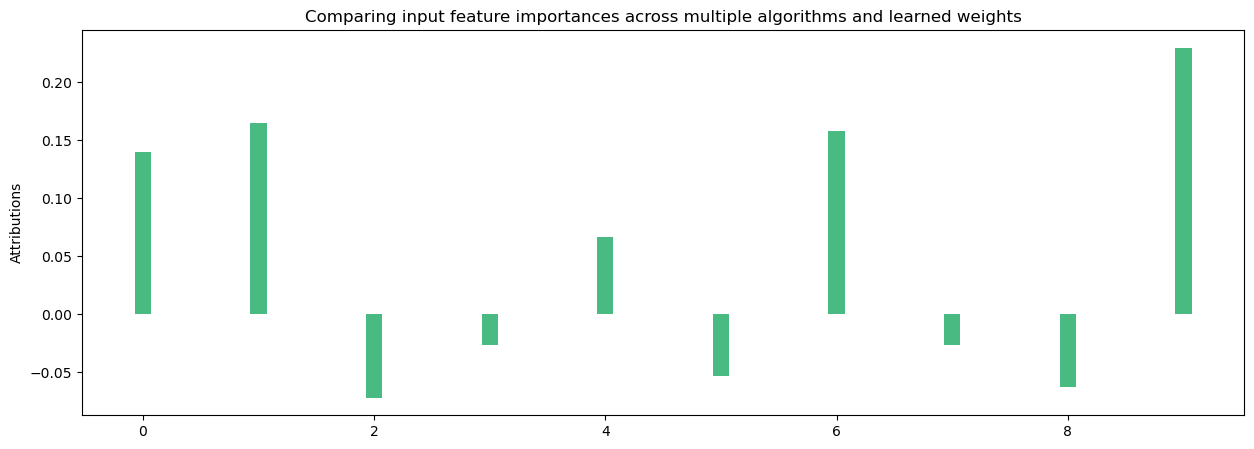

In [30]:
idx = 1
maskA = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glaucoma10-annot-ben/' + test_glaucoma.imagea[idx]))[1] < 0
maskB = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glaucoma10-annot-ben/' + test_glaucoma.imageb[idx]))[1] < 0

imageA = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glauLarge/' + test_glaucoma.imagea[idx]))
imageB = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glauLarge/' + test_glaucoma.imageb[idx]))

fa_attr_test_norm_sum = get_feature_importance([imageA, imageB], ranknet, device, type='10')
importants_idx = np.flip(np.argsort((fa_attr_test_norm_sum)))
topk = 5

plt.figure(figsize=(15, 5))
x_axis_data = np.arange(len(fa_attr_test_norm_sum))
width = 0.14
ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

ax.bar(x_axis_data , fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')

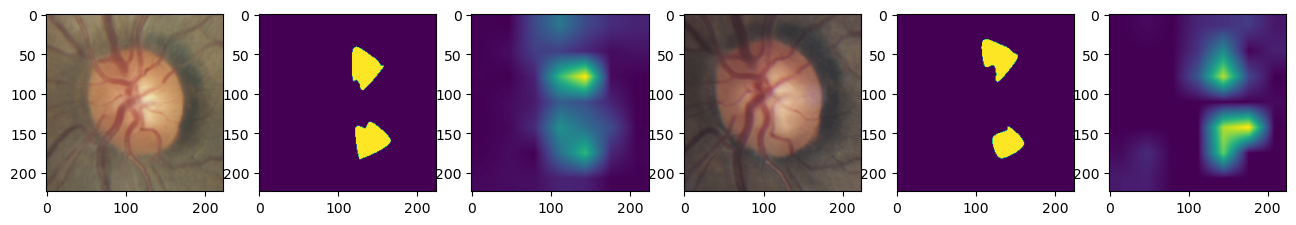

In [38]:
ttt = 1
fA = importants_idx[ttt]
fB = importants_idx[ttt]
rgb_imgA, rgb_imgB, grayscale_camA, grayscale_camB = find_heatmap(ranknet, imageA, imageB, fA, fB, feature_extractor=fextractor)

fig, axes = plt.subplots(1, 6, figsize=(16, 4))
ax = axes.ravel()
ax[0].imshow(imgtensor2array(imageA, mean=mean, std=std))
ax[1].imshow(maskA)
ax[2].imshow(grayscale_camA[0])
ax[3].imshow(imgtensor2array(imageB, mean=mean, std=std))
ax[4].imshow(maskB)
ax[5].imshow(grayscale_camB[0])

In [77]:
from captum.attr import visualization as viz
from captum.attr import Lime, LimeBase, Occlusion
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso
from captum.attr._core.lime import get_exp_kernel_similarity_function
from skimage.segmentation import felzenszwalb

In [78]:
fa_attr_test_norm_sum = get_feature_importance([imageA, imageB], ranknet, device, type='10')
importants_idx = np.flip(np.argsort(fa_attr_test_norm_sum))

In [92]:
from skimage.segmentation import felzenszwalb
imgA = imgtensor2array(imageA, mean, std)
imgB = imgtensor2array(imageB, mean, std)
segments_fz = felzenszwalb(imgA, scale=10, sigma=0.5, min_size=200)

In [103]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [115]:
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)


lr_lime = Lime(model.cpu(), interpretable_model=SkLearnLinearRegression(), similarity_func=exp_eucl_distance)
attributions_limeA = lr_lime.attribute(
    imageA.unsqueeze(0),
    target=int(importants_idx[0]),
    n_samples=500,
    feature_mask = torch.LongTensor(segments_fz),
    perturbations_per_eval=1,
    show_progress=True
).squeeze(0)

attributions_limeB = lr_lime.attribute(
    imageB.unsqueeze(0),
    target=int(importants_idx[0]),
    n_samples=500,
    feature_mask = torch.LongTensor(segments_fz),
    perturbations_per_eval=1,
    show_progress=True
).squeeze(0)

Lime attribution: 100%|██████████| 500/500 [00:13<00:00, 38.37it/s]


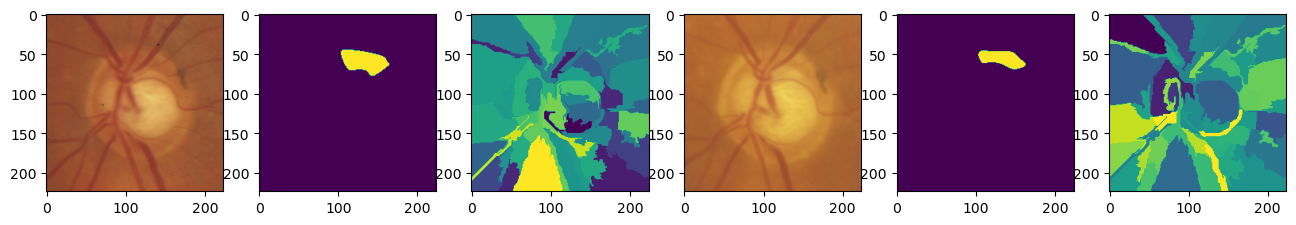

In [116]:
fig, axes = plt.subplots(1, 6, figsize=(16, 4))
ax = axes.ravel()
ax[0].imshow(imgtensor2array(imageA, mean=mean, std=std))
ax[1].imshow(maskA)
ax[2].imshow(attributions_limeA[0])
ax[3].imshow(imgtensor2array(imageB, mean=mean, std=std))
ax[4].imshow(maskB)
ax[5].imshow(attributions_limeB[0])

## Auto Run LiME

In [48]:
from captum.attr import visualization as viz
from captum.attr import Lime, LimeBase, Occlusion
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso
from captum.attr._core.lime import get_exp_kernel_similarity_function
from skimage.segmentation import felzenszwalb

In [59]:
fextractor = 'vit16'

path = f"/mnt/c/Users/PCM/Dropbox/pretrained/mdindex/siamese10/{fextractor}/siaseme10_modemdindex-longtitude_fextravit16_lr0.005_mo0.9_e4_20092023_l100000_cotrainTrue.pt"
fcnet = nn.Sequential(torch.nn.Linear(768, 200),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(200, 64),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(64, 10))
ranknet = RankNet_wresnet2(feature_extractor = fextractor, fcnet=fcnet)
ranknet.load_state_dict(torch.load(path, map_location=torch.device('cpu')), strict=False)
ranknet.eval()
ranknet.to(device)

RankNet_wresnet2(
  (fextractor): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (

In [60]:
# ranknet = RankNet_wresnet2('resnet50')
# ranknet.load_state_dict(torch.load("./pretrained/mdindex_siamese1/siaseme1_modemdindex-longtitude_fextraresnet50_lr0.01_mo0.9_e4_19092023_l100000_cotrainTrue.pt", map_location=torch.device('cpu')))
model = ranknet.fextractor.eval()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
IoUs = []

for idx in range(len(test_glaucoma)):
    maskA = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glaucoma10-annot-ben/' + test_glaucoma.imagea[idx]))[1] < 0
    maskB = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glaucoma10-annot-ben/' + test_glaucoma.imageb[idx]))[1] < 0
    
    imageA = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glauLarge/' + test_glaucoma.imagea[idx].replace('-S.jpg', '-L.jpg')))
    imageB = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glauLarge/' + test_glaucoma.imageb[idx].replace('-S.jpg', '-L.jpg')))
    imgA = imgtensor2array(imageA, mean, std)
    # imgB = imgtensor2array(imageB, mean, std)
    fa_attr_test_norm_sum = get_feature_importance([imageA, imageB], ranknet, device, type='10')
    importants_idx = np.flip(np.argsort(fa_attr_test_norm_sum))
    fA = importants_idx[0]
    fB = importants_idx[0]
    # fA = np.mod(importants_idx[0],32)
    # fB = int(importants_idx[0]/32)
    segments_fz = felzenszwalb(imgA, scale=10, sigma=0.5, min_size=100)
    exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)
    lr_lime = Lime(model.cpu(), interpretable_model=SkLearnLinearRegression(), similarity_func=exp_eucl_distance)

    attributions_limeA = lr_lime.attribute(
        imageA.unsqueeze(0),
        target=int(fA),
        n_samples=400,
        feature_mask = torch.LongTensor(segments_fz),
        perturbations_per_eval=1,
        show_progress=True
    ).squeeze(0)

    attributions_limeB = lr_lime.attribute(
        imageB.unsqueeze(0),
        target=int(fB),
        n_samples=400,
        feature_mask = torch.LongTensor(segments_fz),
        perturbations_per_eval=1,
        show_progress=True
    ).squeeze(0)
    
    threA = np.mean(attributions_limeA[0].numpy()) + np.std(attributions_limeA[0].numpy())
    threB = np.mean(attributions_limeB[0].numpy()) + np.std(attributions_limeB[0].numpy())
    iouA = calculate_iou(maskA.numpy(), attributions_limeA[0].numpy() > threA, False)
    iouB = calculate_iou(maskB.numpy(), attributions_limeB[0].numpy() > threB, False)
    print('iouA', iouA, 'iouB', iouB)
    IoUs.append(iouA)
    IoUs.append(iouB)

Lime attribution: 100%|██████████| 400/400 [00:33<00:00, 12.01it/s]


iouA 0.016059957173447537 iouB 0.020766961651917402


Lime attribution: 100%|██████████| 400/400 [00:33<00:00, 11.96it/s]


iouA 0.015111809923130678 iouB 0.04259634888438134


Lime attribution: 100%|██████████| 400/400 [00:33<00:00, 11.84it/s]


iouA 0.0012636899747262005 iouB 0.1747239263803681


/tmp/ipykernel_14889/2020104976.py:14: RuntimeWarning: invalid value encountered in divide
  fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)
Lime attribution: 100%|██████████| 400/400 [00:33<00:00, 11.94it/s]


iouA 0.06474170990300022 iouB 0.013405867495628521


Lime attribution: 100%|██████████| 400/400 [00:33<00:00, 11.84it/s]

iouA 0.022033898305084745 iouB 0.0986957368113685


In [61]:
np.mean(IoUs)

0.046939990650305324

## GradCAM Siamese 1

In [45]:
fextractor = 'resnet50'
path = f"/mnt/c/Users/PCM/Dropbox/pretrained/mdindex/siamese1/vgg19/siaseme1_modemdindex-longtitude_fextravgg19_lr0.0005_mo0.9_e15_18092023_l10000_cotrainTrue.pt"
# ranknet = RankNet_wresnet(feature_extractor = 'vgg19')
# ranknet.load_state_dict(torch.load("/mnt/c/Users/PCM/Dropbox/pretrained/mdindex/siamese1/vgg19/siaseme1_modemdindex-longtitude_fextravgg19_lr0.0005_mo0.9_e15_18092023_l10000_cotrainFalse.pt", map_location=torch.device('cpu')))

ranknet = RankNet_wresnet(feature_extractor = fextractor)
ranknet.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

RuntimeError: Error(s) in loading state_dict for RankNet_wresnet:
	Missing key(s) in state_dict: "fextractor.conv1.weight", "fextractor.bn1.weight", "fextractor.bn1.bias", "fextractor.bn1.running_mean", "fextractor.bn1.running_var", "fextractor.layer1.0.conv1.weight", "fextractor.layer1.0.bn1.weight", "fextractor.layer1.0.bn1.bias", "fextractor.layer1.0.bn1.running_mean", "fextractor.layer1.0.bn1.running_var", "fextractor.layer1.0.conv2.weight", "fextractor.layer1.0.bn2.weight", "fextractor.layer1.0.bn2.bias", "fextractor.layer1.0.bn2.running_mean", "fextractor.layer1.0.bn2.running_var", "fextractor.layer1.0.conv3.weight", "fextractor.layer1.0.bn3.weight", "fextractor.layer1.0.bn3.bias", "fextractor.layer1.0.bn3.running_mean", "fextractor.layer1.0.bn3.running_var", "fextractor.layer1.0.downsample.0.weight", "fextractor.layer1.0.downsample.1.weight", "fextractor.layer1.0.downsample.1.bias", "fextractor.layer1.0.downsample.1.running_mean", "fextractor.layer1.0.downsample.1.running_var", "fextractor.layer1.1.conv1.weight", "fextractor.layer1.1.bn1.weight", "fextractor.layer1.1.bn1.bias", "fextractor.layer1.1.bn1.running_mean", "fextractor.layer1.1.bn1.running_var", "fextractor.layer1.1.conv2.weight", "fextractor.layer1.1.bn2.weight", "fextractor.layer1.1.bn2.bias", "fextractor.layer1.1.bn2.running_mean", "fextractor.layer1.1.bn2.running_var", "fextractor.layer1.1.conv3.weight", "fextractor.layer1.1.bn3.weight", "fextractor.layer1.1.bn3.bias", "fextractor.layer1.1.bn3.running_mean", "fextractor.layer1.1.bn3.running_var", "fextractor.layer1.2.conv1.weight", "fextractor.layer1.2.bn1.weight", "fextractor.layer1.2.bn1.bias", "fextractor.layer1.2.bn1.running_mean", "fextractor.layer1.2.bn1.running_var", "fextractor.layer1.2.conv2.weight", "fextractor.layer1.2.bn2.weight", "fextractor.layer1.2.bn2.bias", "fextractor.layer1.2.bn2.running_mean", "fextractor.layer1.2.bn2.running_var", "fextractor.layer1.2.conv3.weight", "fextractor.layer1.2.bn3.weight", "fextractor.layer1.2.bn3.bias", "fextractor.layer1.2.bn3.running_mean", "fextractor.layer1.2.bn3.running_var", "fextractor.layer2.0.conv1.weight", "fextractor.layer2.0.bn1.weight", "fextractor.layer2.0.bn1.bias", "fextractor.layer2.0.bn1.running_mean", "fextractor.layer2.0.bn1.running_var", "fextractor.layer2.0.conv2.weight", "fextractor.layer2.0.bn2.weight", "fextractor.layer2.0.bn2.bias", "fextractor.layer2.0.bn2.running_mean", "fextractor.layer2.0.bn2.running_var", "fextractor.layer2.0.conv3.weight", "fextractor.layer2.0.bn3.weight", "fextractor.layer2.0.bn3.bias", "fextractor.layer2.0.bn3.running_mean", "fextractor.layer2.0.bn3.running_var", "fextractor.layer2.0.downsample.0.weight", "fextractor.layer2.0.downsample.1.weight", "fextractor.layer2.0.downsample.1.bias", "fextractor.layer2.0.downsample.1.running_mean", "fextractor.layer2.0.downsample.1.running_var", "fextractor.layer2.1.conv1.weight", "fextractor.layer2.1.bn1.weight", "fextractor.layer2.1.bn1.bias", "fextractor.layer2.1.bn1.running_mean", "fextractor.layer2.1.bn1.running_var", "fextractor.layer2.1.conv2.weight", "fextractor.layer2.1.bn2.weight", "fextractor.layer2.1.bn2.bias", "fextractor.layer2.1.bn2.running_mean", "fextractor.layer2.1.bn2.running_var", "fextractor.layer2.1.conv3.weight", "fextractor.layer2.1.bn3.weight", "fextractor.layer2.1.bn3.bias", "fextractor.layer2.1.bn3.running_mean", "fextractor.layer2.1.bn3.running_var", "fextractor.layer2.2.conv1.weight", "fextractor.layer2.2.bn1.weight", "fextractor.layer2.2.bn1.bias", "fextractor.layer2.2.bn1.running_mean", "fextractor.layer2.2.bn1.running_var", "fextractor.layer2.2.conv2.weight", "fextractor.layer2.2.bn2.weight", "fextractor.layer2.2.bn2.bias", "fextractor.layer2.2.bn2.running_mean", "fextractor.layer2.2.bn2.running_var", "fextractor.layer2.2.conv3.weight", "fextractor.layer2.2.bn3.weight", "fextractor.layer2.2.bn3.bias", "fextractor.layer2.2.bn3.running_mean", "fextractor.layer2.2.bn3.running_var", "fextractor.layer2.3.conv1.weight", "fextractor.layer2.3.bn1.weight", "fextractor.layer2.3.bn1.bias", "fextractor.layer2.3.bn1.running_mean", "fextractor.layer2.3.bn1.running_var", "fextractor.layer2.3.conv2.weight", "fextractor.layer2.3.bn2.weight", "fextractor.layer2.3.bn2.bias", "fextractor.layer2.3.bn2.running_mean", "fextractor.layer2.3.bn2.running_var", "fextractor.layer2.3.conv3.weight", "fextractor.layer2.3.bn3.weight", "fextractor.layer2.3.bn3.bias", "fextractor.layer2.3.bn3.running_mean", "fextractor.layer2.3.bn3.running_var", "fextractor.layer3.0.conv1.weight", "fextractor.layer3.0.bn1.weight", "fextractor.layer3.0.bn1.bias", "fextractor.layer3.0.bn1.running_mean", "fextractor.layer3.0.bn1.running_var", "fextractor.layer3.0.conv2.weight", "fextractor.layer3.0.bn2.weight", "fextractor.layer3.0.bn2.bias", "fextractor.layer3.0.bn2.running_mean", "fextractor.layer3.0.bn2.running_var", "fextractor.layer3.0.conv3.weight", "fextractor.layer3.0.bn3.weight", "fextractor.layer3.0.bn3.bias", "fextractor.layer3.0.bn3.running_mean", "fextractor.layer3.0.bn3.running_var", "fextractor.layer3.0.downsample.0.weight", "fextractor.layer3.0.downsample.1.weight", "fextractor.layer3.0.downsample.1.bias", "fextractor.layer3.0.downsample.1.running_mean", "fextractor.layer3.0.downsample.1.running_var", "fextractor.layer3.1.conv1.weight", "fextractor.layer3.1.bn1.weight", "fextractor.layer3.1.bn1.bias", "fextractor.layer3.1.bn1.running_mean", "fextractor.layer3.1.bn1.running_var", "fextractor.layer3.1.conv2.weight", "fextractor.layer3.1.bn2.weight", "fextractor.layer3.1.bn2.bias", "fextractor.layer3.1.bn2.running_mean", "fextractor.layer3.1.bn2.running_var", "fextractor.layer3.1.conv3.weight", "fextractor.layer3.1.bn3.weight", "fextractor.layer3.1.bn3.bias", "fextractor.layer3.1.bn3.running_mean", "fextractor.layer3.1.bn3.running_var", "fextractor.layer3.2.conv1.weight", "fextractor.layer3.2.bn1.weight", "fextractor.layer3.2.bn1.bias", "fextractor.layer3.2.bn1.running_mean", "fextractor.layer3.2.bn1.running_var", "fextractor.layer3.2.conv2.weight", "fextractor.layer3.2.bn2.weight", "fextractor.layer3.2.bn2.bias", "fextractor.layer3.2.bn2.running_mean", "fextractor.layer3.2.bn2.running_var", "fextractor.layer3.2.conv3.weight", "fextractor.layer3.2.bn3.weight", "fextractor.layer3.2.bn3.bias", "fextractor.layer3.2.bn3.running_mean", "fextractor.layer3.2.bn3.running_var", "fextractor.layer3.3.conv1.weight", "fextractor.layer3.3.bn1.weight", "fextractor.layer3.3.bn1.bias", "fextractor.layer3.3.bn1.running_mean", "fextractor.layer3.3.bn1.running_var", "fextractor.layer3.3.conv2.weight", "fextractor.layer3.3.bn2.weight", "fextractor.layer3.3.bn2.bias", "fextractor.layer3.3.bn2.running_mean", "fextractor.layer3.3.bn2.running_var", "fextractor.layer3.3.conv3.weight", "fextractor.layer3.3.bn3.weight", "fextractor.layer3.3.bn3.bias", "fextractor.layer3.3.bn3.running_mean", "fextractor.layer3.3.bn3.running_var", "fextractor.layer3.4.conv1.weight", "fextractor.layer3.4.bn1.weight", "fextractor.layer3.4.bn1.bias", "fextractor.layer3.4.bn1.running_mean", "fextractor.layer3.4.bn1.running_var", "fextractor.layer3.4.conv2.weight", "fextractor.layer3.4.bn2.weight", "fextractor.layer3.4.bn2.bias", "fextractor.layer3.4.bn2.running_mean", "fextractor.layer3.4.bn2.running_var", "fextractor.layer3.4.conv3.weight", "fextractor.layer3.4.bn3.weight", "fextractor.layer3.4.bn3.bias", "fextractor.layer3.4.bn3.running_mean", "fextractor.layer3.4.bn3.running_var", "fextractor.layer3.5.conv1.weight", "fextractor.layer3.5.bn1.weight", "fextractor.layer3.5.bn1.bias", "fextractor.layer3.5.bn1.running_mean", "fextractor.layer3.5.bn1.running_var", "fextractor.layer3.5.conv2.weight", "fextractor.layer3.5.bn2.weight", "fextractor.layer3.5.bn2.bias", "fextractor.layer3.5.bn2.running_mean", "fextractor.layer3.5.bn2.running_var", "fextractor.layer3.5.conv3.weight", "fextractor.layer3.5.bn3.weight", "fextractor.layer3.5.bn3.bias", "fextractor.layer3.5.bn3.running_mean", "fextractor.layer3.5.bn3.running_var", "fextractor.layer4.0.conv1.weight", "fextractor.layer4.0.bn1.weight", "fextractor.layer4.0.bn1.bias", "fextractor.layer4.0.bn1.running_mean", "fextractor.layer4.0.bn1.running_var", "fextractor.layer4.0.conv2.weight", "fextractor.layer4.0.bn2.weight", "fextractor.layer4.0.bn2.bias", "fextractor.layer4.0.bn2.running_mean", "fextractor.layer4.0.bn2.running_var", "fextractor.layer4.0.conv3.weight", "fextractor.layer4.0.bn3.weight", "fextractor.layer4.0.bn3.bias", "fextractor.layer4.0.bn3.running_mean", "fextractor.layer4.0.bn3.running_var", "fextractor.layer4.0.downsample.0.weight", "fextractor.layer4.0.downsample.1.weight", "fextractor.layer4.0.downsample.1.bias", "fextractor.layer4.0.downsample.1.running_mean", "fextractor.layer4.0.downsample.1.running_var", "fextractor.layer4.1.conv1.weight", "fextractor.layer4.1.bn1.weight", "fextractor.layer4.1.bn1.bias", "fextractor.layer4.1.bn1.running_mean", "fextractor.layer4.1.bn1.running_var", "fextractor.layer4.1.conv2.weight", "fextractor.layer4.1.bn2.weight", "fextractor.layer4.1.bn2.bias", "fextractor.layer4.1.bn2.running_mean", "fextractor.layer4.1.bn2.running_var", "fextractor.layer4.1.conv3.weight", "fextractor.layer4.1.bn3.weight", "fextractor.layer4.1.bn3.bias", "fextractor.layer4.1.bn3.running_mean", "fextractor.layer4.1.bn3.running_var", "fextractor.layer4.2.conv1.weight", "fextractor.layer4.2.bn1.weight", "fextractor.layer4.2.bn1.bias", "fextractor.layer4.2.bn1.running_mean", "fextractor.layer4.2.bn1.running_var", "fextractor.layer4.2.conv2.weight", "fextractor.layer4.2.bn2.weight", "fextractor.layer4.2.bn2.bias", "fextractor.layer4.2.bn2.running_mean", "fextractor.layer4.2.bn2.running_var", "fextractor.layer4.2.conv3.weight", "fextractor.layer4.2.bn3.weight", "fextractor.layer4.2.bn3.bias", "fextractor.layer4.2.bn3.running_mean", "fextractor.layer4.2.bn3.running_var", "fextractor.fc.0.weight", "fextractor.fc.0.bias", "fextractor.fc.3.weight", "fextractor.fc.3.bias", "fextractor.fc.6.weight", "fextractor.fc.6.bias". 
	Unexpected key(s) in state_dict: "fextractor.features.0.weight", "fextractor.features.0.bias", "fextractor.features.2.weight", "fextractor.features.2.bias", "fextractor.features.5.weight", "fextractor.features.5.bias", "fextractor.features.7.weight", "fextractor.features.7.bias", "fextractor.features.10.weight", "fextractor.features.10.bias", "fextractor.features.12.weight", "fextractor.features.12.bias", "fextractor.features.14.weight", "fextractor.features.14.bias", "fextractor.features.16.weight", "fextractor.features.16.bias", "fextractor.features.19.weight", "fextractor.features.19.bias", "fextractor.features.21.weight", "fextractor.features.21.bias", "fextractor.features.23.weight", "fextractor.features.23.bias", "fextractor.features.25.weight", "fextractor.features.25.bias", "fextractor.features.28.weight", "fextractor.features.28.bias", "fextractor.features.30.weight", "fextractor.features.30.bias", "fextractor.features.32.weight", "fextractor.features.32.bias", "fextractor.features.34.weight", "fextractor.features.34.bias", "fextractor.classifier.0.weight", "fextractor.classifier.0.bias", "fextractor.classifier.3.weight", "fextractor.classifier.3.bias", "fextractor.classifier.6.weight", "fextractor.classifier.6.bias". 

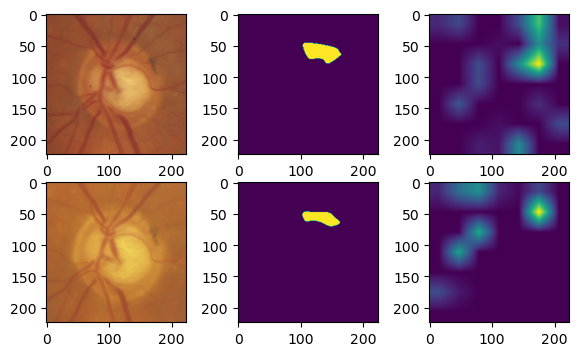

In [10]:
idx = 4
maskA = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glaucoma10-annot-ben/' + test_glaucoma.imagea[idx]))[1] < 0
maskB = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glaucoma10-annot-ben/' + test_glaucoma.imageb[idx]))[1] < 0

imageA = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glauLarge/' + test_glaucoma.imagea[idx]))
imageB = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glauLarge/' + test_glaucoma.imageb[idx]))

rgb_imgA, rgb_imgB, grayscale_camA, grayscale_camB = find_heatmap(ranknet, imageA, imageB, 0, 0, feature_extractor = fextractor)

fig, axes = plt.subplots(2, 3, figsize=(7, 4))
ax = axes.ravel()
ax[0].imshow(imgtensor2array(imageA, mean=mean, std=std))
ax[1].imshow(maskA)
ax[2].imshow(grayscale_camA[0])
ax[3].imshow(imgtensor2array(imageB, mean=mean, std=std))
ax[4].imshow(maskB)
ax[5].imshow(grayscale_camB[0])

### Auto RUN

In [6]:
fextractor = 'resnet50'
path = f"/mnt/c/Users/PCM/Dropbox/pretrained/mdindex/siamese1/simclr-{fextractor}/siaseme1_modemdindex-longtitude_fextraresnet50_lr0.1_mo0.9_e14_29092023_l10000_cotrainFalse.pt"

ranknet = RankNet_wresnet(feature_extractor = fextractor)
ranknet.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
# model = ranknet.fextractor.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
IoUs = []

for idx in range(len(test_glaucoma)):
    maskA = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glaucoma10-annot-ben/' + test_glaucoma.imagea[idx]))[1] < 0
    maskB = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glaucoma10-annot-ben/' + test_glaucoma.imageb[idx]))[1] < 0
    
    imageA = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glauLarge/' + test_glaucoma.imagea[idx].replace('-S.jpg', '-L.jpg')))
    imageB = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glauLarge/' + test_glaucoma.imageb[idx].replace('-S.jpg', '-L.jpg')))
    # imgA = imgtensor2array(imageA, mean, std)
    rgb_imgA, rgb_imgB, grayscale_camA, grayscale_camB = find_heatmap(ranknet, imageA, imageB, 0, 0, feature_extractor = fextractor)

    iouA = calculate_iou(maskA.numpy(), grayscale_camA[0], False)
    iouB = calculate_iou(maskB.numpy(), grayscale_camB[0], False)
    print('iouA', iouA, 'iouB', iouB)
    IoUs.append(iouA)
    IoUs.append(iouB)
print('mIoU = ', np.mean(IoUs))

iouA 0.017379679144385027 iouB 0.03872767857142857
iouA 0.05797132554945055 iouB 0.05038851972901019
iouA 0.02874367774566474 iouB 0.01953125
iouA 0.021765801790339438 iouB 0.04659444060773481
iouA 0.032634493670886076 iouB 0.015536325216341317
mIoU =  0.03292731920252407


## LIME for Siamese 1

In [65]:
from captum.attr import visualization as viz
from captum.attr import Lime, LimeBase, Occlusion
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso
from captum.attr._core.lime import get_exp_kernel_similarity_function
from skimage.segmentation import felzenszwalb

In [70]:
fextractor = 'vit16'

path = f"/mnt/c/Users/PCM/Dropbox/pretrained/mdindex/siamese10/{fextractor}/siaseme10_modemdindex-longtitude_fextravit16_lr0.005_mo0.9_e4_20092023_l100000_cotrainTrue.pt"
fcnet = nn.Sequential(torch.nn.Linear(768, 200),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(200, 64),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(64, 10))
ranknet = RankNet_wresnet2(feature_extractor = fextractor, fcnet=fcnet)
ranknet.load_state_dict(torch.load(path, map_location=torch.device('cpu')), strict=False)
ranknet.eval()
ranknet.to(device)

RankNet_wresnet2(
  (fextractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [71]:
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)
# fextractor = 'vit16'
# path = f"/mnt/c/Users/PCM/Dropbox/pretrained/mdindex/siamese1/{fextractor}/siaseme1_modemdindex-longtitude_fextravit16_lr0.0005_mo0.9_e11_19092023_l10000_cotrainTrue.pt"
# ranknet = RankNet_wresnet(feature_extractor = fextractor)
model = ranknet.fextractor

lr_lime = Lime(model.cpu(), interpretable_model=SkLearnLinearRegression(), similarity_func=exp_eucl_distance)
idx = 2
maskA = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glaucoma10-annot-ben/' + test_glaucoma.imagea[idx]))[1] < 0
maskB = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glaucoma10-annot-ben/' + test_glaucoma.imageb[idx]))[1] < 0

imageA = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glauLarge/' + test_glaucoma.imagea[idx].replace('-S.jpg', '-L.jpg')))
imageB = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glauLarge/' + test_glaucoma.imageb[idx].replace('-S.jpg', '-L.jpg')))
imgA = imgtensor2array(imageA, mean, std)

segments_fz = felzenszwalb(imgA, scale=10, sigma=0.5, min_size=100)
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)
lr_lime = Lime(model.cpu(), interpretable_model=SkLearnLinearRegression(), similarity_func=exp_eucl_distance)

attributions_limeA = lr_lime.attribute(
    imageA.unsqueeze(0),
    target=int(0),
    n_samples=400,
    feature_mask = torch.LongTensor(segments_fz),
    perturbations_per_eval=10,
    show_progress=True
).squeeze(0)

attributions_limeB = lr_lime.attribute(
    imageB.unsqueeze(0),
    target=int(0),
    n_samples=400,
    feature_mask = torch.LongTensor(segments_fz),
    perturbations_per_eval=10,
    show_progress=True
).squeeze(0)

Lime attribution: 100%|██████████| 40/40 [00:12<00:00,  3.31it/s]


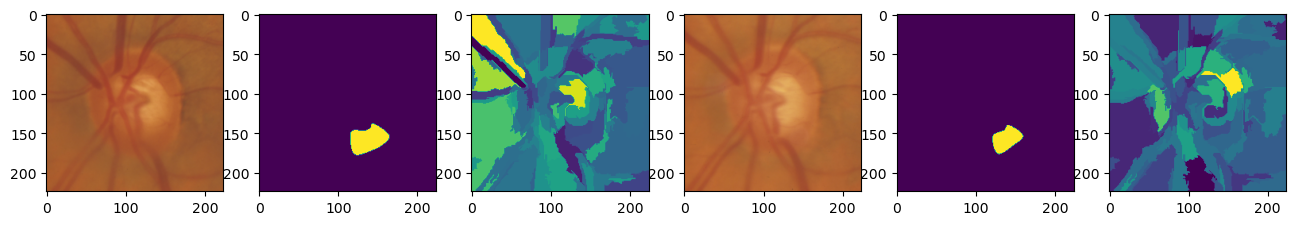

In [72]:
fig, axes = plt.subplots(1, 6, figsize=(16, 4))
ax = axes.ravel()
ax[0].imshow(imgtensor2array(imageA, mean=mean, std=std))
ax[1].imshow(maskA)
ax[2].imshow(attributions_limeA[0])
ax[3].imshow(imgtensor2array(imageB, mean=mean, std=std))
ax[4].imshow(maskB)
ax[5].imshow(attributions_limeB[0])

In [73]:
IoUs = []    
threA = np.mean(attributions_limeA[0].numpy()) + np.std(attributions_limeA[0].numpy())
threB = np.mean(attributions_limeB[0].numpy()) + np.std(attributions_limeB[0].numpy())
iouA = calculate_iou(maskA.numpy(), attributions_limeA[0].numpy() > threA, False)
iouB = calculate_iou(maskB.numpy(), attributions_limeB[0].numpy() > threB, False)
print('iouA', iouA, 'iouB', iouB)
IoUs.append(iouA)
IoUs.append(iouB)
print('meaniou ', np.mean(IoUs))

iouA 0.0 iouB 0.0
meaniou  0.0


In [ ]:
fextractor = 'vit16'

path = f"/mnt/c/Users/PCM/Dropbox/pretrained/mdindex/siamese10/{fextractor}/siaseme10_modemdindex-longtitude_fextravit16_lr0.005_mo0.9_e4_20092023_l100000_cotrainTrue.pt"
fcnet = nn.Sequential(torch.nn.Linear(768, 200),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(200, 64),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(64, 10))
ranknet = RankNet_wresnet2(feature_extractor = fextractor, fcnet=fcnet)
ranknet.load_state_dict(torch.load(path, map_location=torch.device('cpu')), strict=False)
ranknet.eval()
ranknet.to(device)

In [75]:
fextractor = 'vit16'
# path = f"/mnt/c/Users/PCM/Dropbox/pretrained/mdindex/siamese1/{fextractor}/siaseme1_modemdindex-longtitude_fextravit16_lr0.0005_mo0.9_e11_19092023_l10000_cotrainTrue.pt"
# ranknet = RankNet_wresnet(feature_extractor = fextractor)
# ranknet.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
model = ranknet.fextractor
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
IoUs = []

for idx in range(len(test_glaucoma)):
    maskA = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glaucoma10-annot-ben/' + test_glaucoma.imagea[idx]))[1] < 0
    maskB = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glaucoma10-annot-ben/' + test_glaucoma.imageb[idx]))[1] < 0
    
    imageA = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glauLarge/' + test_glaucoma.imagea[idx].replace('-S.jpg', '-L.jpg')))
    imageB = data_transforms['test'](Image.open('/mnt/c/Users/PCM/Dropbox/glauLarge/' + test_glaucoma.imageb[idx].replace('-S.jpg', '-L.jpg')))
    imgA = imgtensor2array(imageA, mean, std)

    segments_fz = felzenszwalb(imgA, scale=10, sigma=0.5, min_size=100)
    exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)
    lr_lime = Lime(model.cpu(), interpretable_model=SkLearnLinearRegression(), similarity_func=exp_eucl_distance)

    attributions_limeA = lr_lime.attribute(
        imageA.unsqueeze(0),
        target=int(0),
        n_samples=400,
        feature_mask = torch.LongTensor(segments_fz),
        perturbations_per_eval=1,
        show_progress=True
    ).squeeze(0)

    attributions_limeB = lr_lime.attribute(
        imageB.unsqueeze(0),
        target=int(0),
        n_samples=400,
        feature_mask = torch.LongTensor(segments_fz),
        perturbations_per_eval=1,
        show_progress=True
    ).squeeze(0)
    
    threA = np.mean(attributions_limeA[0].numpy()) + np.std(attributions_limeA[0].numpy())
    threB = np.mean(attributions_limeB[0].numpy()) + np.std(attributions_limeB[0].numpy())
    iouA = calculate_iou(maskA.numpy(), attributions_limeA[0].numpy() > threA, False)
    iouB = calculate_iou(maskB.numpy(), attributions_limeB[0].numpy() > threB, False)
    print('iouA', iouA, 'iouB', iouB)
    IoUs.append(iouA)
    IoUs.append(iouB)

Lime attribution: 100%|██████████| 400/400 [00:33<00:00, 11.91it/s]


iouA 0.07579605391678063 iouB 0.01626767723449487


Lime attribution: 100%|██████████| 400/400 [00:31<00:00, 12.72it/s]


iouA 0.004770367598914975 iouB 0.0


Lime attribution: 100%|██████████| 400/400 [00:31<00:00, 12.59it/s]


iouA 0.0012214983713355048 iouB 0.07472590882862089


Lime attribution: 100%|██████████| 400/400 [00:32<00:00, 12.43it/s]


iouA 0.0 iouB 0.0


Lime attribution: 100%|██████████| 400/400 [00:32<00:00, 12.43it/s]

iouA 0.01835522764081339 iouB 0.09967662164732738


In [77]:
np.mean(IoUs)

0.02908133552382876